In [80]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import random as rnd
%pip install scikit-image -q
from skimage.util import view_as_windows
from scipy.ndimage import median_filter

Note: you may need to restart the kernel to use updated packages.


In [81]:
%load_ext autoreload
%autoreload 

import os
import sys
# add path ../src to sys
sys.path.append(os.path.join(os.getcwd(), '../src'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
from blockfy import Blockfy
from basisgen import BasisGenerator

In [83]:
P,Q = 8,8
bg = BasisGenerator(P,Q, uv_orientation=True)

basisMatrix = bg.generate_basis_matrix()

## Create k-folds for training and validation

In [84]:
S = 30
m = S//6 # test-training split 80-20
M = 20 # number of training samples
img_path = '../assets/fishing_boat/fishing_boat.bmp'

In [85]:
bi = Blockfy(img_path, (P,Q), P)
bi.generate_blocks()
corrpt_blocks = bi.generate_corrupted_blocks(sensed_pixels=S)

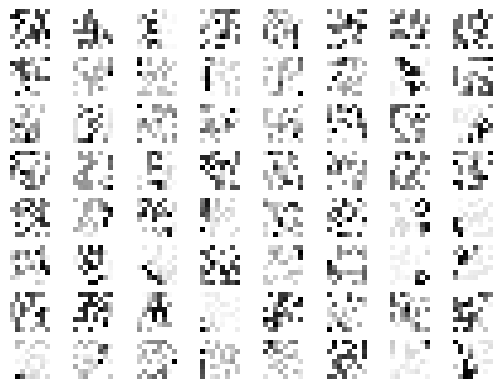

In [86]:
for i in range(P*Q):
    plt.subplot(P,Q,i+1)
    plt.imshow(corrpt_blocks[i], cmap='gray')
    plt.axis('off')

In [87]:
rkf = RepeatedKFold(n_splits=m, n_repeats=M)
for i in range(len(corrpt_blocks)):
    chip_flat = corrpt_blocks[i].flatten()
    good_pixels_idx = np.where(~np.isnan(chip_flat))[0]
    good_pixels_idx = good_pixels_idx.astype(int)
    chip_flat = chip_flat[good_pixels_idx]
    bm_chip = basisMatrix[good_pixels_idx]
    
    rkf.get_n_splits(bm_chip, chip_flat)
    train_index, test_index = next(iter(rkf.split(bm_chip)))
    
    alpha = np.logspace(-9,9,20)
    mse_chip = []
    
    rec_chips = []
    corrup_chips = []
    mse_values = []
    
    for j,a in enumerate(alpha):
        lasso = Lasso(alpha=a, fit_intercept=False)
        lasso.fit(bm_chip[train_index], chip_flat[train_index])
        
        recov_chip = np.sum(
            lasso.coef_.reshape(-1,1,1) * basisMatrix.T.reshape(-1,P,P), axis=0
        )
        
        masked_corrupt_chip = np.full_like(corrpt_blocks[i], np.nan)
        for idx in good_pixels_idx[test_index]:  # Use indices array to map back to original image positions
            masked_corrupt_chip.flat[idx] = corrpt_blocks[i].flat[idx]
            
        masked_reconstruct_chip = np.full_like(corrpt_blocks[i], np.nan)
        for idx in good_pixels_idx[test_index]:  # Use indices array to map back to original image positions
            masked_reconstruct_chip.flat[idx] = recov_chip.flat[idx]
        
        rec_chips.append(masked_reconstruct_chip)
        corrup_chips.append(masked_corrupt_chip)
        
        # Calculate MSE
        valid_pixels = ~np.isnan(masked_corrupt_chip) & ~np.isnan(masked_reconstruct_chip)
        
        if np.any(valid_pixels):
            mse = mean_squared_error(masked_corrupt_chip[valid_pixels], masked_reconstruct_chip[valid_pixels])
            mse_values.append(mse)
        else:
            mse_values.append(np.nan)
            print('Warning: No valid pixels in MSE calculation')
    
    # get index of minimum MSE
    min_mse_idx = np.nanargmin(mse_values)
    min_mse_alpha = alpha[min_mse_idx]
    
    print(f'Block {i+1} - Minimum MSE: {mse_values[min_mse_idx]}, Alpha: {min_mse_alpha}')

Block 1 - Minimum MSE: 0.18564470055721263, Alpha: 5.4555947811685143e-05
Block 2 - Minimum MSE: 14.77737817391234, Alpha: 0.03792690190732246
Block 3 - Minimum MSE: 328.0253085405263, Alpha: 0.33598182862837744
Block 4 - Minimum MSE: 1.856610369302188, Alpha: 0.0004832930238571752
Block 5 - Minimum MSE: 2.012983815360052, Alpha: 0.03792690190732246
Block 6 - Minimum MSE: 5.805410291315842, Alpha: 0.03792690190732246
Block 7 - Minimum MSE: 3.5482323047516715, Alpha: 0.004281332398719387
Block 8 - Minimum MSE: 2.540864035580084, Alpha: 1e-09
Block 9 - Minimum MSE: 5.743193947482735, Alpha: 0.004281332398719387
Block 10 - Minimum MSE: 23.374710119276, Alpha: 0.33598182862837744
Block 11 - Minimum MSE: 35.568371298857805, Alpha: 0.0004832930238571752
Block 12 - Minimum MSE: 367.76391186987684, Alpha: 0.004281332398719387
Block 13 - Minimum MSE: 15.699559894723448, Alpha: 0.004281332398719387
Block 14 - Minimum MSE: 24.315417777599922, Alpha: 0.33598182862837744
Block 15 - Minimum MSE: 160

/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+01, tolerance: 3.110e+01
  model = cd_fast.enet_coordinate_descent(


Block 251 - Minimum MSE: 98.64529504667348, Alpha: 0.03792690190732246
Block 252 - Minimum MSE: 113.87675189631399, Alpha: 0.004281332398719387
Block 253 - Minimum MSE: 108.29236888826136, Alpha: 0.004281332398719387
Block 254 - Minimum MSE: 288.25370042900767, Alpha: 0.004281332398719387
Block 255 - Minimum MSE: 9.921783434801606, Alpha: 0.0004832930238571752
Block 256 - Minimum MSE: 1029.421472048941, Alpha: 0.03792690190732246
Block 257 - Minimum MSE: 22.908218025122196, Alpha: 0.03792690190732246
Block 258 - Minimum MSE: 49.25795490299735, Alpha: 0.03792690190732246
Block 259 - Minimum MSE: 578.5339392853234, Alpha: 0.004281332398719387
Block 260 - Minimum MSE: 133.1262021039009, Alpha: 0.0004832930238571752
Block 261 - Minimum MSE: 307.8941453275176, Alpha: 0.03792690190732246
Block 262 - Minimum MSE: 365.81937803878463, Alpha: 0.03792690190732246
Block 263 - Minimum MSE: 748.4740529566039, Alpha: 0.33598182862837744
Block 264 - Minimum MSE: 27.432953983649416, Alpha: 0.0004832930

/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e+01, tolerance: 1.232e+01
  model = cd_fast.enet_coordinate_descent(


Block 380 - Minimum MSE: 82.47789009104861, Alpha: 0.0004832930238571752
Block 381 - Minimum MSE: 24.297948250404673, Alpha: 0.0004832930238571752
Block 382 - Minimum MSE: 109.94788929558263, Alpha: 0.004281332398719387
Block 383 - Minimum MSE: 99.2959945606515, Alpha: 0.03792690190732246
Block 384 - Minimum MSE: 471.06903887700327, Alpha: 2.976351441631313
Block 385 - Minimum MSE: 429.2713710698129, Alpha: 1e-09
Block 386 - Minimum MSE: 619.9968473528603, Alpha: 0.0004832930238571752
Block 387 - Minimum MSE: 768.2967349982081, Alpha: 0.0004832930238571752
Block 388 - Minimum MSE: 942.2926893947262, Alpha: 0.004281332398719387
Block 389 - Minimum MSE: 437.6252163451167, Alpha: 0.004281332398719387
Block 390 - Minimum MSE: 239.07696705435896, Alpha: 0.0004832930238571752
Block 391 - Minimum MSE: 1119.457871152062, Alpha: 0.004281332398719387
Block 392 - Minimum MSE: 360.9290224583646, Alpha: 0.004281332398719387
Block 393 - Minimum MSE: 150.10147340504506, Alpha: 0.0004832930238571752
B

/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.781e+00, tolerance: 6.486e+00
  model = cd_fast.enet_coordinate_descent(


Block 429 - Minimum MSE: 63.42895121463252, Alpha: 5.4555947811685143e-05
Block 430 - Minimum MSE: 46.78519436730712, Alpha: 1e-09
Block 431 - Minimum MSE: 41.1022639487758, Alpha: 0.03792690190732246
Block 432 - Minimum MSE: 320.36334093156427, Alpha: 5.4555947811685143e-05
Block 433 - Minimum MSE: 527.1896861671828, Alpha: 0.004281332398719387
Block 434 - Minimum MSE: 35.55533148093266, Alpha: 1e-09
Block 435 - Minimum MSE: 757.1920039622831, Alpha: 0.33598182862837744
Block 436 - Minimum MSE: 1329.769480627394, Alpha: 0.33598182862837744
Block 437 - Minimum MSE: 26.975728582900498, Alpha: 0.03792690190732246
Block 438 - Minimum MSE: 5.546012633887295, Alpha: 0.03792690190732246
Block 439 - Minimum MSE: 104.90493588450632, Alpha: 5.4555947811685143e-05
Block 440 - Minimum MSE: 1833.6673130001648, Alpha: 0.03792690190732246
Block 441 - Minimum MSE: 207.19025973428856, Alpha: 0.0004832930238571752
Block 442 - Minimum MSE: 312.1727716985705, Alpha: 0.03792690190732246
Block 443 - Minimu

/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+01, tolerance: 1.151e+01
  model = cd_fast.enet_coordinate_descent(
/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+01, tolerance: 1.151e+01
  model = cd_fast.enet_coordinate_descent(


Block 468 - Minimum MSE: 125.83870048175244, Alpha: 0.0004832930238571752
Block 469 - Minimum MSE: 100.79579456399358, Alpha: 0.004281332398719387
Block 470 - Minimum MSE: 154.2658823673742, Alpha: 0.33598182862837744
Block 471 - Minimum MSE: 124.58040525527771, Alpha: 0.03792690190732246
Block 472 - Minimum MSE: 159.76898130820177, Alpha: 0.0004832930238571752
Block 473 - Minimum MSE: 73.47370923895066, Alpha: 0.004281332398719387
Block 474 - Minimum MSE: 555.3212407037021, Alpha: 0.03792690190732246
Block 475 - Minimum MSE: 210.0497933241207, Alpha: 0.03792690190732246
Block 476 - Minimum MSE: 224.334954547431, Alpha: 0.004281332398719387
Block 477 - Minimum MSE: 11.03487077395628, Alpha: 0.33598182862837744
Block 478 - Minimum MSE: 14.994809983311058, Alpha: 0.0004832930238571752
Block 479 - Minimum MSE: 13.529526546860069, Alpha: 0.03792690190732246
Block 480 - Minimum MSE: 101.13798920192228, Alpha: 0.004281332398719387
Block 481 - Minimum MSE: 76.90228575800766, Alpha: 0.03792690

/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.786e+00, tolerance: 2.132e+00
  model = cd_fast.enet_coordinate_descent(


## Function streamline best alpha selection for lasso each chip

In [88]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from Blockfy import BlockifyImage
from BasisGenerator import BasisGenerator


class LassoAlphaOptimizer:
    """A class for optimizing alpha parameters for Lasso regression on image blocks.

    This class provides functionality to:
    1. Optimize alpha parameters for Lasso regression on corrupted image blocks
    2. Return the best alpha parameters for each block

    Attributes:
        S (int): Number of sensed pixels per block
        M (int): Number of training samples
        test_train_split (float): Ratio of test to training data (e.g., 0.2 for 80-20 split)
        P (int): Height of the basis chips
        Q (int): Width of the basis chips
        basis_generator (BasisGenerator): Instance of BasisGenerator for generating basis matrices
        blockifier (BlockifyImage): Instance of BlockifyImage for processing image blocks
    """

    def __init__(self, S: int, M: int, test_train_split: float = 0.2, P: int = 8, Q: int = 8):
        """Initialize the LassoAlphaOptimizer instance.

        Args:
            S (int): Number of sensed pixels per block
            M (int): Number of training samples
            test_train_split (float): Ratio of test to training data (default: 0.2)
            P (int): Height of the basis chips (default: 8)
            Q (int): Width of the basis chips (default: 8)
        """
        self.S = S
        self.M = M
        self.test_train_split = test_train_split
        self.P = P
        self.Q = Q
        self.basis_generator = BasisGenerator(P, Q, uv_orientation=True)
        self.blockifier = None

    def optimize_alphas(self, img_path: str) -> np.ndarray:
        """Optimize alpha parameters for Lasso regression on corrupted image blocks.

        Args:
            img_path (str): Path to the input image file

        Returns:
            numpy.ndarray: Array of best alpha parameters for each block
        """
        # Initialize BlockifyImage
        self.blockifier = BlockifyImage(img_path, (self.P, self.Q), self.P)
        self.blockifier.generate_blocks()
        corrupted_blocks = self.blockifier.generate_corrupted_blocks(sensed_pixels=self.S)

        # Generate basis matrix
        basis_matrix = self.basis_generator.generate_basis_matrix()

        # Initialize RepeatedKFold
        m = int(self.S * self.test_train_split)  # Number of test samples
        rkf = RepeatedKFold(n_splits=m, n_repeats=self.M)

        # Array to store best alphas for each block
        best_alphas = np.zeros(self.P * self.Q)

        # Iterate over each block
        for i in range(self.P * self.Q):
            chip_flat = corrupted_blocks[i].flatten()
            good_pixels_idx = np.where(~np.isnan(chip_flat))[0].astype(int)
            chip_flat = chip_flat[good_pixels_idx]
            bm_chip = basis_matrix[good_pixels_idx]

            # Initialize MSE values
            alpha = np.logspace(-6, 6, 20)
            mse_values = []

            # Perform cross-validation
            for a in alpha:
                mse_fold = []
                for train_index, test_index in rkf.split(bm_chip):
                    lasso = Lasso(alpha=a, fit_intercept=False)
                    lasso.fit(bm_chip[train_index], chip_flat[train_index])

                    # Reconstruct the chip
                    recov_chip = np.sum(
                        lasso.coef_.reshape(-1, 1, 1) * basis_matrix.T.reshape(-1, self.P, self.P), axis=0
                    )

                    # Mask the reconstructed and corrupted chips
                    masked_corrupt_chip = np.full_like(corrupted_blocks[i], np.nan)
                    masked_corrupt_chip.flat[good_pixels_idx[test_index]] = corrupted_blocks[i].flat[good_pixels_idx[test_index]]

                    masked_reconstruct_chip = np.full_like(corrupted_blocks[i], np.nan)
                    masked_reconstruct_chip.flat[good_pixels_idx[test_index]] = recov_chip.flat[good_pixels_idx[test_index]]

                    # Calculate MSE
                    valid_pixels = ~np.isnan(masked_corrupt_chip) & ~np.isnan(masked_reconstruct_chip)
                    if np.any(valid_pixels):
                        mse = mean_squared_error(
                            masked_corrupt_chip[valid_pixels], masked_reconstruct_chip[valid_pixels]
                        )
                        mse_fold.append(mse)
                    else:
                        mse_fold.append(np.nan)

                # Average MSE across folds
                mse_values.append(np.nanmean(mse_fold))

            # Find the best alpha
            min_mse_idx = np.nanargmin(mse_values)
            best_alphas[i] = alpha[min_mse_idx]

        return best_alphas

ModuleNotFoundError: No module named 'Blockfy'

In [ ]:
# Initialize the LassoAlphaOptimizer
optimizer = LassoAlphaOptimizer(S=30, M=20, test_train_split=0.2)

# Optimize alphas for an image
img_path = '../assets/fishing_boat/fishing_boat.bmp'
best_alphas = optimizer.optimize_alphas(img_path)

# Print the best alphas
print("Best Alphas for Each Block:", best_alphas)

/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.543e+01, tolerance: 4.502e+01
  model = cd_fast.enet_coordinate_descent(
/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.572e+01, tolerance: 4.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/wanghley/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

Best Alphas for Each Block: [1.43844989e-03 1.43844989e-03 4.83293024e-01 6.15848211e-03
 1.00000000e-06 6.15848211e-03 1.12883789e-01 1.43844989e-03
 6.15848211e-03 1.43844989e-03 4.83293024e-01 6.15848211e-03
 1.12883789e-01 1.43844989e-03 1.43844989e-03 1.12883789e-01
 2.63665090e-02 6.15848211e-03 2.63665090e-02 1.43844989e-03
 1.43844989e-03 2.63665090e-02 7.84759970e-05 1.43844989e-03
 1.12883789e-01 1.12883789e-01 1.12883789e-01 1.43844989e-03
 6.15848211e-03 6.15848211e-03 1.43844989e-03 1.12883789e-01
 1.43844989e-03 2.63665090e-02 2.63665090e-02 6.15848211e-03
 6.15848211e-03 2.63665090e-02 6.15848211e-03 6.15848211e-03
 1.43844989e-03 4.83293024e-01 1.43844989e-03 2.63665090e-02
 1.43844989e-03 2.63665090e-02 1.43844989e-03 1.43844989e-03
 1.12883789e-01 1.43844989e-03 1.43844989e-03 6.15848211e-03
 1.12883789e-01 6.15848211e-03 1.43844989e-03 3.35981829e-04
 1.43844989e-03 6.15848211e-03 1.43844989e-03 4.83293024e-01
 1.12883789e-01 6.15848211e-03 4.83293024e-01 1.12883789e